# CESM-LE analysis
### Looks snow melt dynamics from individual grid cells
 - reading in ensemble of data from CESM2_LENS
 - here, looking at daily SNOWDP & QRUNOFF over water year (Oct - Sept)
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import cartopy.crs as ccrs

import numba
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from tqdm.auto import tqdm
from distributed import wait

%matplotlib inline

In [2]:
print('xarray '+xr.__version__) ## was working with 17.0
print('dask '+dask.__version__) ## was working with 2021.02.0

xarray 0.17.0
dask 2021.02.0


### run this cell to check if you have LENS2 read access:

In [3]:
samplefile = ('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/NBP/'+
              'b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [4]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [5]:
cluster, client = get_ClusterClient(nmem='4GB')
cluster.scale(150)

In [6]:
cluster

In [7]:
#client.restart()
#cluster.close()

### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [8]:
def get_members(model):
    members = []
    if model =='CESM1':
        members = [str(i).zfill(3) for i in [*(1+np.arange(35)),*(101+np.arange(7))]]
    else:
        for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
            s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
            members.append(s)
        for i in [1231,1251,1281,1301]:
            for j in 1+np.arange(10):
                s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
                members.append(s)
    return members

In [9]:
## Updated for new directory structure of LENS2
def file_dict(model,mem,field,hist=True,freq='monthly',component='lnd'):
    ''' returns a dictionary of filepaths keyed by year, for a given ensemble member '''
    mm = get_members(model)[mem]

    filepaths = {}
    
    if model=='CESM1':
        #detailing the directory structure
        topdir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+ \
                  component+'/proc/tseries/'
        if freq =='monthly': 
            freq = 'monthly/'
            tape = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'
        if hist: runtype = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        else:    runtype = 'b.e11.BRCP85C5CNBDRD.f09_g16.'
        #find all the relevant files
        files = glob.glob(thisdir+runtype+'*'+tape+field+'*')
    else:
        #detailing the directory structure
        topdir  = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/'+ \
                   component+'/proc/tseries/'
        if freq=='monthly':
            freq    = 'month_1/'
            tape    = '.h0.'
        elif freq=='daily':
            freq    = 'day_1/'
            if component == 'lnd': tape    = '.h5.'
            if component == 'atm': tape    = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'

        if hist: runtype = 'b.e21.BHISTcmip6.f09_g17.'
        else:    runtype = 'b.e21.BSSP370cmip6.f09_g17.'

        #find all the relevant files
        files = glob.glob(thisdir+runtype+mm+'*'+tape+field+'*')

    for file in files:
        #isolate y1 and y2 from the file name
        ystr = file.split(field)[-1]
        y1 = int(ystr[1:5])
        ystr = ystr.split('-')[1]
        y2 = int(ystr[0:4])
        for yy in np.arange(y1,y2+1):
            filepaths[yy]=file
        
    return filepaths


In [10]:
def get_file(model,mem,field,year,freq='monthly',component='lnd'):
    ''' get a single file for the given model-mem-field-year'''
    hist = True
    if model=='CESM1' and year>2005: hist=False
    if model=='CESM2' and year>2014: hist=False

    filepaths = file_dict(model,mem,field,hist,freq,component)
    if year in filepaths.keys():
        file = filepaths[year]
    else:
        print('file not found for that member')
        file = []
    
    return file

In [11]:
def all_files(model,ens,field,firstyear,lastyear,
              freq='monthly',component='lnd'):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        file0 = ''
        first = True
        for yr in yrs:
            #fetch filepaths
            if first:
                hist = True
                if model=='CESM1' and yr>2005: hist=False
                if model=='CESM2' and yr>2014: hist=False
                filepaths = file_dict(model,ee,field,hist,freq,component)
                first     = False  
            #append file if it is new
            if yr in filepaths.keys():
                file = filepaths[yr]
                if file != file0:
                    ffs.append(file)
                    file0 = file

            #trigger new filepaths fetch when needed
            if model=='CESM1' and yr==2005: first=True
            if model=='CESM2' and yr==2014: first=True

        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [12]:
def get_data(model,ens,fields,firstyear,lastyear,freq,preprocess,
             component='lnd',chunks={'time':1000}, 
            ):#Preprocess=False,plat=None,plon=None):
    ''' returns an xarray dataset containing the requested ensemble
    model = \'CESM1\' or \'CESM2\'
    ens   = list of members, via simple sequential key 
            e.g. range(50) gets the first 50 members
            [0,2,4] would get the first, third, 
            and fifth ensemble members (see get_members)
    fields = list of desired fields, you do not need to ask for lat/lon/time
    firstyear = int [1850-2100]
    lastyear  = int [1850-2100]
    freq = \'monthly\' or \'daily\' '''

    ds = xr.Dataset()    #instantiate Dataset
    
    #allow for single field or list of fields
    if type(fields)==str: fields=[fields]  
    
    #add fields one at a time to the dataset
    for field in fields:
        files,ens = all_files(model,ens,field,firstyear,lastyear,
                              freq,component)
        ensdim  = xr.DataArray(ens, dims='ens', name='ens')
        dims    = [ensdim,'time']

        # check if all members have the same number of files (not guaranteed)
        nfs = np.array([len(ffs) for ffs in files])
        if np.sum(nfs==nfs[0])==len(nfs):
            one_go=True   # same number of files
        else:
            one_go=False
        if one_go: #read all data in one go
            tmp = xr.open_mfdataset(files,preprocess=preprocess,
                                    combine='nested',parallel=True,
                                    concat_dim=dims,chunks=chunks,
                                    )
        else:      #read data one member at a time and then concat
            dsets = []
            for ffs in files:
                d0 = xr.open_mfdataset(ffs,preprocess=preprocess,
                                       combine='nested',parallel=True,
                                       concat_dim=['time'],chunks=chunks,
                                       )
                dsets.append(d0)
            tmp = xr.concat(dsets,dim=ensdim)
        ds[field] = tmp[field]

    #grab one copy of the various extra variables, e.g. landfrac,area
    tmp = xr.open_dataset(files[0][0])
    for thisvar in tmp.data_vars:
        if 'time' not in tmp[thisvar].coords:
            ds[thisvar]=tmp[thisvar]

    # quick fix to adjust time vector for monthly data        
    if freq=='monthly':
        nmonths = len(ds.time)
        yr0 = ds['time.year'][0].values
        ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

    return ds.sel(time=slice(str(firstyear),str(lastyear)))

In [13]:
def get_landarea(model):
    file= get_file(model,0,'GPP',1990)
    ds = xr.open_dataset(file)
    la = ds['area']*ds['landfrac']
    return la

In [14]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

--------------------
# Start editing here:

### Actually read in data
- Here monthly data for the whole ensemble

In [21]:
model = 'CESM2'
ens = 10+np.arange(40)
nens = len(ens)
WaterYear = False

# maybe use SWE = H2OSNO = (SNOWLIQ + SNOWICE) instead of snow depth?
fields = ['QRUNOFF','H2OSNO']
firstyear = 1850
lastyear  = 2100
freq      = 'monthly'

def preprocess(ds):
    '''keep only the lat-lon'''
    return ds

dsMonth = get_data(model,ens,fields,firstyear,lastyear,freq,preprocess)

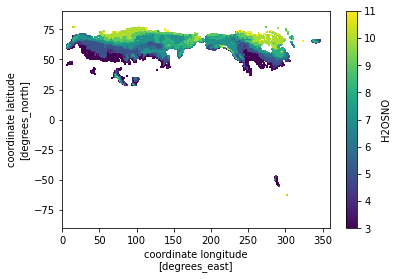

In [22]:
# create a mask for grids, as used for ToE annual stats in VernalWindow notebook
minSWE = 30 # mm water

# monthly means, averaged over ensembles
dsMask = dsMonth.H2OSNO.groupby('time.month').mean().mean('ens')

# count months with SWE > minVal
dsMask = xr.where(dsMask>minSWE, 1, 0).sum('month')

# Mask out < 3 months or snow covered 
dsMask = dsMask.where(dsMask >=3)  
dsMask = dsMask.where(dsMask <12)
dsMask.plot();

In [23]:
dsMask  = dsMask.persist()
dsMonth = dsMonth.where(dsMask>0)

---
## Read in daily data & select regions for plotting
- this seems to max out cpu, with low memory use
- let's ask for more workers above with less memory requested

In [18]:
%%time
freq      = 'daily'
region = 'Southern Rockies'
#104–109°W, 37–41°N
SRlat= [36.7,41]
SRlon= [(360-109),(360-104.5)]
def preprocess(ds):
    '''keep only the lat-lon'''
    return ds.sel(lat= slice(SRlat[0],SRlat[1]), lon=slice(SRlon[0],SRlon[1]))

dsREG = get_data(model,ens,fields,firstyear,lastyear,freq,preprocess)
# mask out regions with low/no snow, as elsewhere
dsREG = dsREG.where(
    dsMask.sel(
        lat= slice(SRlat[0],SRlat[1]), 
        lon=slice(SRlon[0],SRlon[1])
    )>0
)

dsREG = dsREG.mean(['lat','lon']).persist()

_ = wait(dsREG)
print('-- subset '+region+' data -- ')

-- subset Southern Rockies data -- 
CPU times: user 5min 31s, sys: 7.02 s, total: 5min 38s
Wall time: 5min 51s


In [19]:
%%time
freq      = 'daily'
region2 = 'Northern Rockies'
#113–117°W, 43–49°N
NRlat= [43.3,49]
NRlon= [(360-117),(360-113.1)]

def preprocess(ds):
    '''keep only the lat-lon'''
    return ds.sel(lat= slice(NRlat[0],NRlat[1]), lon=slice(NRlon[0],NRlon[1]) )

dsREG2 = get_data(model,ens,fields,firstyear,lastyear,freq,preprocess)
# mask out regions with low/no snow, as elsewhere
dsREG2 = dsREG2.where(dsMask.sel(
    lat= slice(NRlat[0],NRlat[1]), 
    lon=slice(NRlon[0],NRlon[1]))>0)
dsREG2 = dsREG2.mean(['lat','lon']).persist()
_ = wait(dsREG2)
print('-- subset '+region2+' data -- ')

-- subset Northern Rockies data -- 
CPU times: user 5min 34s, sys: 5.99 s, total: 5min 40s
Wall time: 5min 51s


In [20]:
#dsREG
# Merge the regional datasets 
regions=[region,region2]
dsREG = xr.concat([dsREG,dsREG2], dim='regions')
dsREG = dsREG.assign_coords({'regions': regions})

## Plot max snow in Western US, 1850's

/glade/scratch/wwieder/VernalWindow/FigS1.pdf


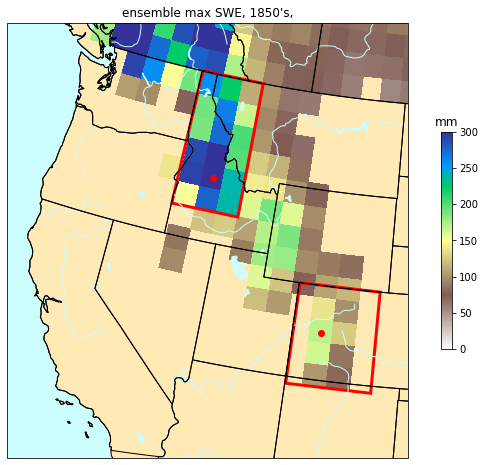

In [23]:
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

plat = [39,44.7, 40]
plon = [252.5,360-115, 254]
site = ['Crested Butte, CO','Frank Church Wilderness, ID', 'Niwot Ridge, CO']

conus_proj = ccrs.LambertConformal(central_longitude=-96,central_latitude=39.0)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1,projection=conus_proj)
ax.set_extent([-123,-104,34,50])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN, facecolor='#CCFEFF')
ax.add_feature(cfeature.LAKES, facecolor='#CCFEFF')
ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
ax.add_feature(cfeature.RIVERS, edgecolor='#CCFEFF')

# -- draw box around S. Rockies -- 
#104–109°W, 37–41°N
lat_corners = np.array([SRlat[0], SRlat[0], SRlat[1], SRlat[1]])
lon_corners = np.array([SRlon[0], SRlon[1], SRlon[1], SRlon[0]])

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners

poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=False,lw=3, transform=ccrs.Geodetic())
ax.add_patch(poly)

# -- draw box around N. Rockies -- 
lat_corners = np.array([NRlat[0], NRlat[0], NRlat[1], NRlat[1]])
lon_corners = np.array([NRlon[0], NRlon[1], NRlon[1], NRlon[0]])

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners

poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=False,lw=3, transform=ccrs.Geodetic())
ax.add_patch(poly)

# -- filled contours, ensemble mean, max snow in first decade ==
cf = ax.pcolormesh(dsMonth.lon, dsMonth.lat, 
                   dsMonth.H2OSNO.isel(time=slice(0,120)).mean('ens').max(dim='time'), 
                   vmin=0,vmax=300, cmap='terrain_r',
                   transform=ccrs.PlateCarree());
#cf = ax.pcolormesh(dsREG2.lon, dsREG2.lat, dsREG2.H2OSNO.isel(ens=1, time=slice(0,120)).max(dim='time'), 
#                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title(dsMonth.H2OSNO.attrs['units'])
ax.set_title("ensemble max SWE, 1850's,");
plt.plot(plon[0:2], plat[0:2],
         color='red', linewidth=0, marker='o',
         transform=ccrs.Geodetic(),
         )

pathIN = '/glade/scratch/wwieder/VernalWindow/'
fileOUT =  pathIN + 'FigS1.pdf' ;
print(fileOUT)
plt.savefig(fileOUT) ;

plt.show()

### Calculate running mean for daily QRUNOFF to smooth results
- convert units to mm/d
- this block is kind of slow, 
- TODO, changing time chunks would make more efficient?

In [24]:
%%time 
s2d = 3600 * 24
dsREG['QRUNOFF'] = dsREG.QRUNOFF.chunk({"time": 1000}).rolling(
    time=21, center=True).mean()
dsREG['QRUNOFF'] = (dsREG['QRUNOFF'] *s2d).persist()
_ = wait(dsREG['QRUNOFF'])

# rename units
dsREG['QRUNOFF'].attrs['units'] = 'mm/d'

# Get chunks for Qrunnoff back to 'normal'
#dsPT['QRUNOFF'] = dsPT.QRUNOFF.chunk({"time": 1000})
#dsREG['QRUNOFF'] = dsREG.QRUNOFF.chunk({"time": 1000})

print('-- runoff smoothed --')

-- runoff smoothed --
CPU times: user 1min 11s, sys: 1.36 s, total: 1min 12s
Wall time: 1min 12s


-----
## Read in SNOWTEL observations & summary statistics

In [15]:
obsPathIN = '/glade/u/home/wwieder/python/cesm-lens/notebooks/maxSWE*.nc'
obsIN = xr.open_mfdataset(obsPathIN).persist()
_ = wait(obsIN)
obsIN['time'] = obsIN.year.squeeze().values
print(' -- Observations read in -- ')

 -- Observations read in -- 


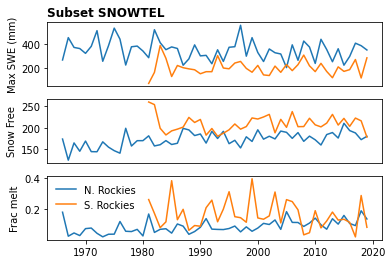

In [20]:
plt.figure(1)
plt.subplot(311)
obsIN.northRockies_maxSWE_subset.mean('noRockiesSNOTEL_subset').plot(x='time') 
obsIN.southRockies_maxSWE_subset.mean('soRockiesSNOTEL_subset').plot(x='time') 
plt.title('Subset SNOWTEL',loc='left', fontsize='large', fontweight='bold')
plt.ylabel('Max SWE (mm)')
plt.xlabel(None)
plt.xticks([])
plt.subplot(312)
obsIN.northRockies_snowFree_subset.mean('noRockiesSNOTEL_subset').plot(x='time') 
obsIN.southRockies_snowFree_subset.mean('soRockiesSNOTEL_subset').plot(x='time') ;
plt.ylabel('Snow Free')
plt.xlabel(None)
plt.xticks([])
plt.subplot(313)
obsIN.northRockies_fracMelt_subset.mean('noRockiesSNOTEL_subset').plot(x='time') 
obsIN.southRockies_fracMelt_subset.mean('soRockiesSNOTEL_subset').plot(x='time') ;
plt.xlabel(None)
plt.ylabel('Frac melt')
plt.legend(['N. Rockies','S. Rockies'],frameon=False) ;

Text(0.5, 0, '')

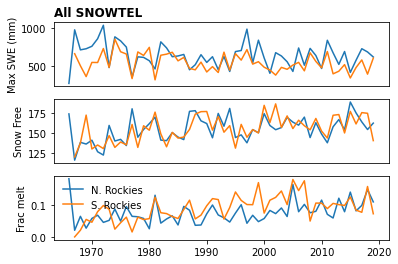

distributed.core - ERROR - 'tcp://10.12.206.15:33766'
Traceback (most recent call last):
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/core.py", line 572, in handle_stream
    handler(**merge(extra, msg))
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/scheduler.py", line 4576, in handle_release_data
    ws: WorkerState = parent._workers_dv[worker]
KeyError: 'tcp://10.12.206.15:33766'
distributed.utils - ERROR - 'tcp://10.12.206.15:33766'
Traceback (most recent call last):
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/utils.py", line 655, in log_errors
    yield
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/scheduler.py", line 3603, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/sched

In [39]:
plt.figure(1)
plt.subplot(311)
obsIN.northRockies_maxSWE_30yrs.mean('noRockiesSNOTEL_30yrs').plot(x='time') 
obsIN.southRockies_maxSWE_30yrs.mean('soRockiesSNOTEL_30yrs').plot(x='time') 
plt.title('All SNOWTEL',loc='left', fontsize='large', fontweight='bold')
plt.ylabel('Max SWE (mm)')
plt.xlabel(None)
plt.xticks([])

plt.subplot(312)
obsIN.northRockies_snowFree_30yrs.mean('noRockiesSNOTEL_30yrs').plot(x='time') 
obsIN.southRockies_snowFree_30yrs.mean('soRockiesSNOTEL_30yrs').plot(x='time') ;
plt.ylabel('Snow Free')
plt.xlabel(None)
plt.xticks([])

plt.subplot(313)
obsIN.northRockies_fracMelt_30yrs.mean('noRockiesSNOTEL_30yrs').plot(x='time') 
obsIN.southRockies_fracMelt_30yrs.mean('soRockiesSNOTEL_30yrs').plot(x='time') ;
plt.ylabel('Frac melt')
plt.legend(['N. Rockies','S. Rockies'],frameon=False) ;
plt.xlabel(None)

In [28]:
print(obsIN)

<xarray.Dataset>
Dimensions:                        (noRockiesSNOTEL_30yrs: 78, noRockiesSNOTEL_subset: 25, single: 1, soRockiesSNOTEL_30yrs: 71, soRockiesSNOTEL_subset: 4, time: 54)
Coordinates:
  * time                           (time) float32 1.966e+03 ... 2.019e+03
Dimensions without coordinates: noRockiesSNOTEL_30yrs, noRockiesSNOTEL_subset, single, soRockiesSNOTEL_30yrs, soRockiesSNOTEL_subset
Data variables:
    northRockies_maxSWE_subset     (time, noRockiesSNOTEL_subset) float32 dask.array<chunksize=(54, 25), meta=np.ndarray>
    southRockies_maxSWE_subset     (time, soRockiesSNOTEL_subset) float32 dask.array<chunksize=(54, 4), meta=np.ndarray>
    northRockies_maxSWE_30yrs      (time, noRockiesSNOTEL_30yrs) float32 dask.array<chunksize=(54, 78), meta=np.ndarray>
    southRockies_maxSWE_30yrs      (time, soRockiesSNOTEL_30yrs) float32 dask.array<chunksize=(54, 71), meta=np.ndarray>
    northRockies_fracMelt_subset   (time, noRockiesSNOTEL_subset) float32 dask.array<chunksize=(

In [24]:
pathIN = '/glade/scratch/wwieder/VernalWindow/SnowStatsSWE*.nc'
ds = xr.open_mfdataset(pathIN,combine='nested',parallel=True,
                                    concat_dim=['ens']).persist()
_ = wait(ds)
print(' -- Data read in -- ')

# Need to make last year of runoff variables zero
qvars = ['MaxQrun','MaxQrunDate','TotQrun','WinMELT','f_WinMELT']
for i in range(len(qvars)):
    ds[qvars[i]] = ds[qvars[i]].where(ds.time<2100)
    
# set day of first and last snow to day of water years
svars = ['LastSnowFree','FirstSnowFree']
for i in range(len(svars)):
    ds[svars[i]] = ds[svars[i]]+92
    ds[svars[i]] = ds[svars[i]].where(ds[svars[i]]<365, ds[svars[i]]-365)
    ds[svars[i]].attrs['long_name'] = svars[i]

ds['SnowFree'].attrs['long_name'] = "Snow free days"

#Mask out missing values (again)
ds = ds.where(ds['SnowFree']>=0)

 -- Data read in -- 


In [25]:
regions = ['Southern Rockies','Northern Rockies']
plat = [slice(36.7,41),
        slice(43.3,49) ]
plon = [slice((360-109),(360-104.5)),
        slice((360-117),(360-113.1))]
p=0
annREG = ds.sel(lat = plat[p], lon = plon[p]).mean(['lat','lon'])
p=1
annREG2 = ds.sel(lat = plat[p], lon = plon[p]).mean(['lat','lon'])
annREG = xr.concat([annREG,annREG2], dim='regions')
annREG = annREG.assign_coords({'regions': regions})
annREG = annREG.isel(time = slice(0,-1))  #skip 2100 data, since WY not finished

### Calculate annual summaries 
- ensemble means, stats and time of emergence

In [26]:
%%time
# ensemble mean of annual data
ds_ensMean = ds.mean('ens',skipna=True).compute()
ds_REGMean = annREG.mean('ens',skipna=True).compute()
_ = wait(ds_ensMean)

ds_ensStd = ds.std('ens',skipna=True).compute()
ds_REGStd = annREG.std('ens',skipna=True).compute()
_ = wait(ds_ensStd)

# add attributes
for ii in ds.data_vars:
    ds_ensMean[ii].attrs = ds[ii].attrs
    ds_ensStd[ii].attrs  = ds[ii].attrs
    ds_REGMean[ii].attrs = ds[ii].attrs
    ds_REGStd[ii].attrs  = ds[ii].attrs

#ds_REGMean = ds_REGMean.isel(time = slice(0,-1))
#ds_REGStd = ds_REGStd.isel(time = slice(0,-1))

CPU times: user 2.11 s, sys: 897 ms, total: 3.01 s
Wall time: 14.2 s


In [27]:
# ensemble mean and std 1940-1969
dsBase    = annREG.isel(time=slice(90,120)).mean(dim=['time','ens']).compute()
dsBaseStd = annREG.isel(time=slice(90,120)).std(dim=['time','ens']).compute()

# Then take mean and std over rolling mean
ds_roll = annREG.rolling(time=10, center=True).mean().compute()
roll_REGMean = ds_roll.mean('ens').compute()
roll_REGStd  = ds_roll.std('ens').compute()
#print('lat = '+str(plat[p])+' lon = '+str(plon[p]))

----
## Take regional ensemble mean of daily data 
- over region of N. and S. Rockies & plot

In [33]:
Ycoords = dsREG[fields[0]].mean(dim=['ens']).coords
Y, Ystd  = xr.Dataset(coords=Ycoords), xr.Dataset(coords=Ycoords) 
Y2,Y2std = xr.Dataset(coords=Ycoords), xr.Dataset(coords=Ycoords)

for i in range(len(fields)):
    Y[fields[i]]    = dsREG[fields[i]].mean(dim='ens').compute()
    Ystd[fields[i]] = dsREG[fields[i]].std(dim='ens').persist()
        
year = np.unique(dsREG['time.year'].values)
print(' -- Finished regional ensemble means -- ')

# Shift to water year
shift = -273  #starts water year Oct 1
Y = Y.shift(time=shift)
Ystd = Ystd.shift(time=shift)

# shift time coords too
Y['time'] = Y.time.shift(time=shift)
Ystd['time'] = Ystd.time.shift(time=shift)
print('   ready to plot mean annual cycle of daily data')

 -- Finished regional ensemble means -- 
   ready to plot mean annual cycle of daily data


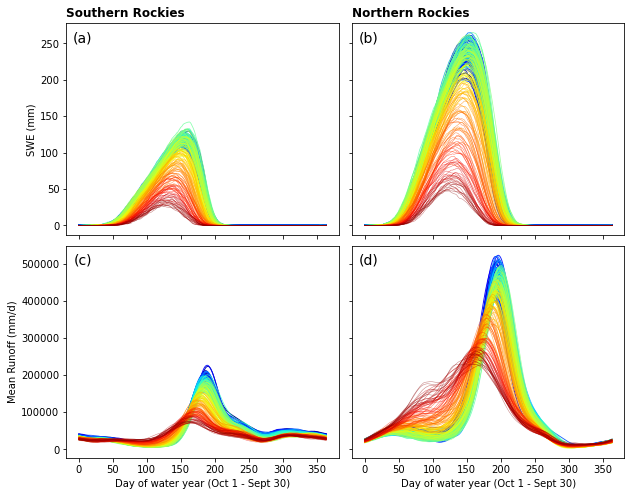

In [34]:
import matplotlib.colors as mcolors
nspan = 1
nyear = int(len(year)/nspan)
alpha = np.linspace(1.,0.5,nyear) 
lw = np.linspace(1.,0.5,nyear) 
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, 
                                sharey='row', sharex='col',
                                gridspec_kw={'wspace': 0.05, 'hspace':0.05},
                                figsize=(10,8))

color = iter(cm.jet(np.linspace(0,1,nyear)))
for i in range(nyear-1):
    #print(year[(i*nspan)])
    firstDay = 365*i*nspan
    lastDay = firstDay + 365
    y = Y.isel(time=slice(firstDay,lastDay) )
    y2 = Y2.isel(time=slice(firstDay,lastDay) )
    c = next(color)
    ax1.plot(y.H2OSNO.isel(regions=0),c=c,lw=lw[i],alpha=alpha[i]) 
    ax2.plot(y.H2OSNO.isel(regions=1),c=c,lw=lw[i],alpha=alpha[i]) 
    ax3.plot(y.QRUNOFF.isel(regions=0),c=c,lw=lw[i],alpha=alpha[i]) 
    ax4.plot(y.QRUNOFF.isel(regions=1),c=c,lw=lw[i],alpha=alpha[i]) 

ax1.set_title(regions[0], loc='left', 
              fontsize='large', fontweight='bold')
ax2.set_title(regions[1], loc='left', 
              fontsize='large', fontweight='bold')
ax1.set_ylabel('SWE (mm)') ;
ax3.set_ylabel('Mean Runoff (mm/d)') ;
ax3.set_xlabel('Day of water year (Oct 1 - Sept 30)') ;
ax4.set_xlabel('Day of water year (Oct 1 - Sept 30)') ;

ax1.annotate('(a)', xy=(0.06, 0.93), xycoords=ax1.transAxes,
                ha='center', va='center',fontsize=14) 
ax2.annotate('(b)', xy=(0.06, 0.93), xycoords=ax2.transAxes,
                ha='center', va='center',fontsize=14) 
ax3.annotate('(c)', xy=(0.06, 0.93), xycoords=ax3.transAxes,
                ha='center', va='center',fontsize=14) 
ax4.annotate('(d)', xy=(0.06, 0.93), xycoords=ax4.transAxes,
                ha='center', va='center',fontsize=14);

<Figure size 1296x432 with 0 Axes>

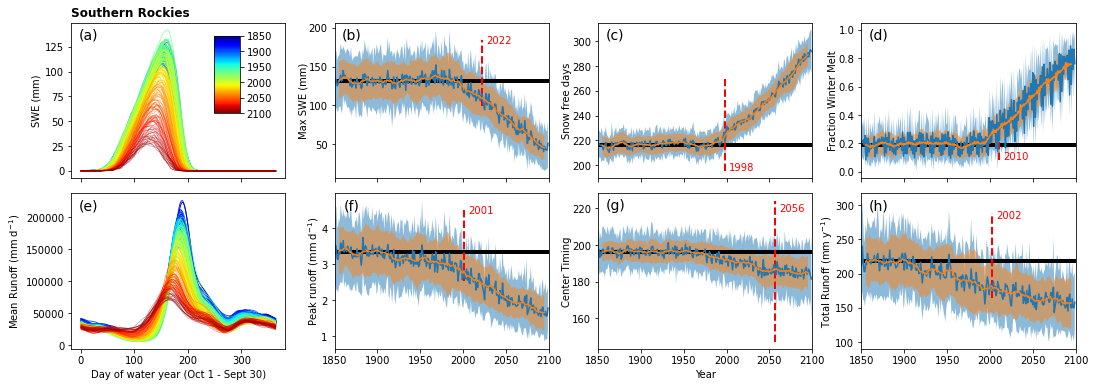

<Figure size 1296x432 with 0 Axes>

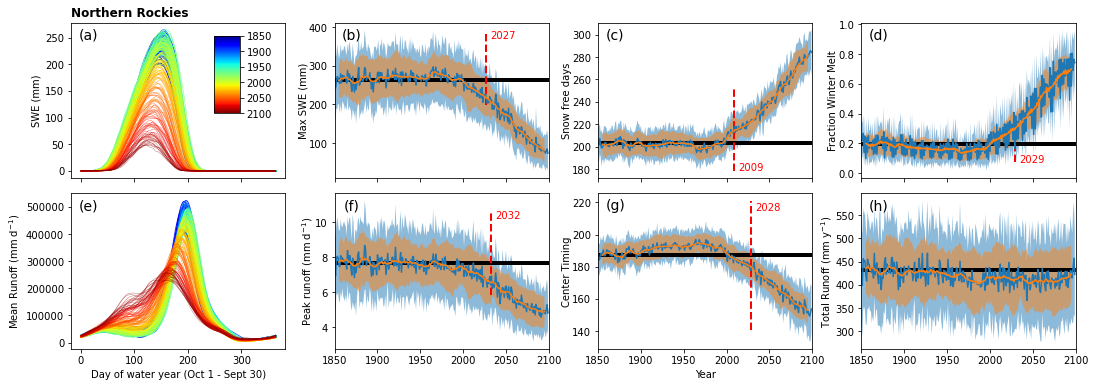

In [35]:
day_vars = ['H2OSNO','QRUNOFF']
in_vars = ['MaxSnow','SnowFree','f_WinMELT',
           'MaxQrun','CT','TotQrun']
sno_vars = ['Max SWE (mm)', 'Snow free days', 'Fraction Winter Melt',
            'Peak runoff (mm $\mathregular{d^{-1}}$)',
            'Center Timing',
            'Total Runoff (mm $\mathregular{y^{-1}}$)']
sno_trend = ['neg','pos','pos',
             'neg','neg','neg']
ID = ['(b)','(c)','(d)','(f)','(g)','(h)']

#select the region to plot here
for p in range(len(regions)):
    plt.figure(figsize=[18,6])
    fig, axs = plt.subplots(2,4, sharex='col',
                            gridspec_kw={'wspace': 0.23, 'hspace': 0.1},
                            figsize=(18,6))


    nspan = 1
    nyear = int(len(year)/nspan)
    alpha = np.linspace(1.,0.5,nyear) 
    lw = np.linspace(1.,0.5,nyear) 

    i,j = 0,0
    ## Plot chagnes in the annual cycle
    for i in range(2):
        color = iter(cm.jet(np.linspace(0,1,nyear)))
        for yr in range(nyear-1):
            #print(year[(i*nspan)])
            firstDay = 365*yr*nspan
            lastDay = firstDay + 365
            #x = Y.time.isel(time=slice(firstDay,lastDay))
            y = Y.isel(regions=p,time=slice(firstDay,lastDay))

            c = next(color)
            axs[i,j].plot(y[day_vars[i]],c=c,lw=lw[yr],alpha=alpha[yr]) 

        if i == 0: 
            axs[i,j].set_title(regions[p],
                               loc='left', fontsize='large', fontweight='bold')
            axs[i,j].set_ylabel('SWE (mm)') 
            axs[i,j].annotate('(a)', xy=(0.08, 0.92), xycoords=axs[i,j].transAxes,
                        ha='center', va='center',fontsize=14) 

        else:
            axs[i,j].set_ylabel('Mean Runoff (mm $\mathregular{d^{-1}}$)') ;
            axs[i,j].set_xlabel('Day of water year (Oct 1 - Sept 30)') ;
            axs[i,j].annotate('(e)', xy=(0.08, 0.92), xycoords=axs[i,j].transAxes,
                        ha='center', va='center',fontsize=14) 

    ### Plot time series of annual metrics
    # move counter for panel
    i,j = 0,1
    for v in range(len(sno_vars)):
        # ens mean
        x = ds_REGMean.time
        y = ds_REGMean[in_vars[v]].isel(regions=p)
        y2 = ds_REGStd[in_vars[v]].isel(regions=p)

        axs[i,j].plot(x, y, '-')
        axs[i,j].fill_between(x, y - y2, y + y2, alpha=0.5)
        axs[i,j].set_ylabel(sno_vars[v],labelpad=0.) ;

        # rolling ensemble mean
        x = roll_REGMean.time
        y = roll_REGMean[in_vars[v]].isel(regions=p)
        y2= roll_REGStd[in_vars[v]].isel(regions=p)
        axs[i,j].plot(x, y)
        axs[i,j].set_xlim(1850,2100)
        axs[i,j].fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

        # baseline
        axs[i,j].hlines(dsBase[in_vars[v]].isel(regions=p),
                        1850, 2100, colors='k',lw=4) ;

        # find last day when roll mean - 2 std < baseline
        if sno_trend[v] == 'pos':  # variables w/ positive trend:
            test = y - 2*y2
            test = test.where(test<dsBase[in_vars[v]].isel(regions=p)).dropna('time')
        else:
            test = y + 2*y2
            test = test.where(test>dsBase[in_vars[v]].isel(regions=p)).dropna('time')

        ToE = test.time.isel(time=-1)
        #draw ToE lines
        if ToE <2095:
            if sno_trend[v] == 'pos': 
                axs[i,j].vlines(ToE, test.min()*0.95,test.max()*1.25,colors='r',
                                lw=2,linestyles='dashed') ;
                axs[i,j].text(ToE+5, test.min()*0.95, ToE.values,color='r')
            else: 
                axs[i,j].vlines(ToE, test.min()*0.75,test.max()*1.1,colors='r',
                                lw=2,linestyles='dashed') ;
                axs[i,j].text(ToE+5, test.max()*1.07, ToE.values,color='r')
        #add panel label
        axs[i,j].annotate(ID[v], xy=(0.08, 0.92), xycoords=axs[i,j].transAxes,
                        ha='center', va='center',fontsize=14) 
        if v == 4:
            axs[i,j].set_xlabel('Year') ;

        # move counter for panel
        j = j+1
        if j == 4:
            i = i+1
            j = 1 ;


    # Fake a ScalarMappable so you can display a colormap
    nvalues=nyear
    cmap, norm = mcolors.from_levels_and_colors(range(1850,2101), 
                                                cm.jet(np.linspace(0,1,(nyear-1))))
    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    #Specifying figure coordinates works fine:
    fig_coord = [0.235,0.67,0.02,0.18]
    cbar_ax = fig.add_axes(fig_coord)

    # tick mark levels
    clevs = [1850,1900,1950,2000,2050,2100]

    fig.colorbar(sm,cax=cbar_ax,
                 orientation='vertical', 
                 ticks=clevs).ax.invert_yaxis() ;

-----
## Plot ensemble mean for individual points
#### Read in daily data for points

In [28]:
%%time
WaterYear = False   # logical for converting time to water year, used below
freq      = 'daily'

# Select individual points
'''# Rocky = 40.44° N, 105.75° W (Alpine visitor center)
# Yellowstone = 44.6568° N, 111.0899° W (West entrance)
# Glacier = 48.7596° N, 113.7870° W

plat = [40.45, 44.66 ,48.5]  
plon = [360-105.75, 360-111.09, 360-113.97]
site = ['Rocky Mountain NP','Yellowstone NP', 'Glacier NP']
'''
# This is a little far west for NWT, but gets a grid with more snow.
# This is a little far west for NWT, but gets a grid with more snow.
plat = [39,44.7, 40]
plon = [252.5,360-115, 254]
site = ['Crested Butte, CO','Frank Church Wilderness, ID', 'Niwot Ridge, CO']

#plat = [39 , 40.0, 64.8]  
#plon = [253, 254., 212.4]
#site = ['Aspen, CO','Niwot Ridge', 'Fairbanks, AK']

def preprocess(ds):
    '''keep only the lat-lon'''
    return ds.sel(lat= plat, lon=plon,method='nearest' )

# the first site from this list will be used for the finale plot, below.
dsPT = get_data(model,ens,fields,firstyear,lastyear,freq,preprocess).persist()
_ = wait(dsPT)

print('-- subset points data -- ')

-- subset points data -- 
CPU times: user 4min 35s, sys: 4.92 s, total: 4min 39s
Wall time: 5min 7s


#### Rolling mean of daily runoff

In [29]:
s2d = 3600 * 24
dsPT['QRUNOFF'] = dsPT.QRUNOFF.chunk({"time": 1000}).rolling(
    time=21, center=True).mean()
dsPT['QRUNOFF'] = (dsPT['QRUNOFF'] *s2d).persist()
_ = wait(dsPT['QRUNOFF'])


dsPT['QRUNOFF'].attrs['units'] = 'mm/d'


#### Compute ensemble statistics on daily data

In [30]:
Ycoords = dsPT[fields[0]].mean(dim=['ens']).coords
Y,    Ystd = xr.Dataset(coords=Ycoords), xr.Dataset(coords=Ycoords)
Ymin, Ymax = xr.Dataset(coords=Ycoords), xr.Dataset(coords=Ycoords)

for i in range(len(fields)):
    print('starting '+ fields[i])
    Y[fields[i]]    = dsPT[fields[i]].mean(dim=['ens']).compute()
    Ystd[fields[i]] = dsPT[fields[i]].std(dim=['ens']).persist()
    
year = np.unique(dsPT['time.year'].values)
print(' -- Finished ensemble means for points -- ')
# shift results to water year
shift = -273  #starts water year Oct 1
Y = Y.shift(time=shift)
Ystd = Ystd.shift(time=shift)

# shift time coords too
Y['time'] = Y.time.shift(time=shift)
Ystd['time'] = Ystd.time.shift(time=shift)

starting QRUNOFF
starting H2OSNO
 -- Finished ensemble means for points -- 


#### Plot daily ensemble means

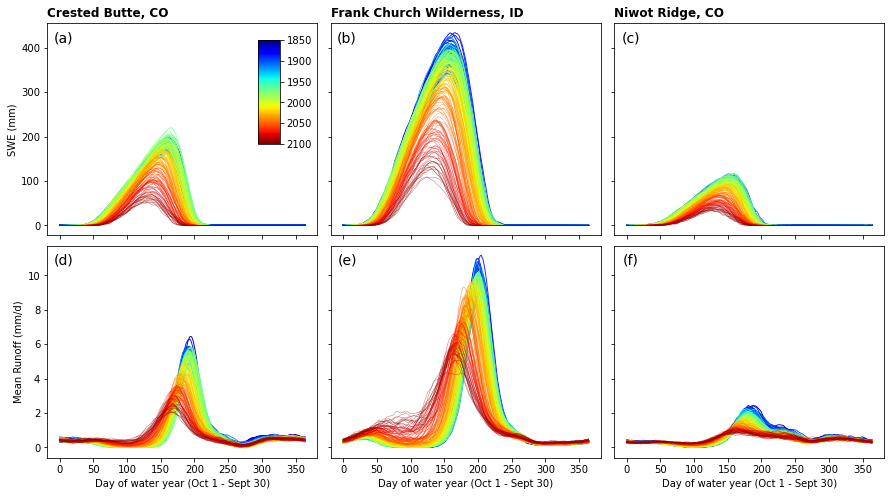

In [31]:
import matplotlib.colors as mcolors
nspan = 1
nyear = int(len(year)/nspan)
alpha = np.linspace(1.,0.5,nyear) 
lw = np.linspace(1.,0.5,nyear) 
fig, ((ax1, ax2,ax3), (ax4, ax5,ax6)) = plt.subplots(2, 3, 
                                sharey='row', sharex='col',
                                gridspec_kw={'wspace': 0.05, 'hspace':0.05},
                                figsize=(15,8))

for h in range(len(site)):
    color = iter(cm.jet(np.linspace(0,1,nyear)))
    for i in range(nyear-1):
        #print(year[(i*nspan)])
        firstDay = 365*i*nspan
        lastDay = firstDay + 365
        x = Y.time.isel(time=slice(firstDay,lastDay))
        y = Y.isel(time=slice(firstDay,lastDay), 
                   lat=h,lon=h)
        c = next(color)
        if h == 0: 
            ax1.plot(y.H2OSNO,c=c,lw=lw[i],alpha=alpha[i]) 
            ax4.plot(y.QRUNOFF,c=c,lw=lw[i],alpha=alpha[i]) 
        if h == 1:
            ax2.plot(y.H2OSNO,c=c,lw=lw[i],alpha=alpha[i]) 
            ax5.plot(y.QRUNOFF,c=c,lw=lw[i],alpha=alpha[i]) 
        if h == 2:
            ax3.plot(y.H2OSNO,c=c,lw=lw[i],alpha=alpha[i]) 
            ax6.plot(y.QRUNOFF,c=c,lw=lw[i],alpha=alpha[i]) 
#months = mdates.MonthLocator((10,11,12,1,2,3,4,5,6,7,8,9))  # every month   
#fmt = mdates.DateFormatter('%b')
#ax.xaxis.set_major_locator(months)
#ax.xaxis.set_major_formatter(fmt)
ax1.set_title(site[0], loc='left', 
              fontsize='large', fontweight='bold')
ax1.set_ylabel('SWE (mm)') ;
ax2.set_title(site[1], loc='left', 
              fontsize='large', fontweight='bold')
ax3.set_title(site[2], loc='left', 
              fontsize='large', fontweight='bold')
ax4.set_ylabel('Mean Runoff (mm/d)') ;
ax4.set_xlabel('Day of water year (Oct 1 - Sept 30)') ;
ax5.set_xlabel('Day of water year (Oct 1 - Sept 30)') ;
ax6.set_xlabel('Day of water year (Oct 1 - Sept 30)') ;

ax1.annotate('(a)', xy=(0.06, 0.93), xycoords=ax1.transAxes,
                ha='center', va='center',fontsize=14) 
ax2.annotate('(b)', xy=(0.06, 0.93), xycoords=ax2.transAxes,
                ha='center', va='center',fontsize=14) 
ax3.annotate('(c)', xy=(0.06, 0.93), xycoords=ax3.transAxes,
                ha='center', va='center',fontsize=14) 
ax4.annotate('(d)', xy=(0.06, 0.93), xycoords=ax4.transAxes,
                ha='center', va='center',fontsize=14) 
ax5.annotate('(e)', xy=(0.06, 0.93), xycoords=ax5.transAxes,
                ha='center', va='center',fontsize=14) 
ax6.annotate('(f)', xy=(0.06, 0.93), xycoords=ax6.transAxes,
                ha='center', va='center',fontsize=14) 

# Fake a ScalarMappable so you can display a colormap
nvalues=nyear
cmap, norm = mcolors.from_levels_and_colors(range(1850,2101), 
                                            cm.jet(np.linspace(0,1,(nyear-1))))
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

#Specifying figure coordinates works fine:
fig_coord = [0.32,0.67,0.02,0.18]
cbar_ax = fig.add_axes(fig_coord)

# tick mark levels
clevs = [1850,1900,1950,2000,2050,2100]

fig.colorbar(sm,cax=cbar_ax,
             orientation='vertical', 
             ticks=clevs).ax.invert_yaxis() ;

### Plot annual cycle and annual trends inc. TOE calculations for individual grids
- read in data calculated in VernalWindow script
- calculate ensemble rolling means, SD 

In [32]:
# ensemble mean and std, 1940-1969
ds = ds.isel(time = slice(0,-1))  #skip 2100 data, since WY not finished
dsBase    = ds.isel(time=slice(90,120)).mean(dim=['time','ens']).compute()
dsBaseStd = ds.isel(time=slice(90,120)).std(dim=['time','ens']).compute()

# Then take mean and std over rolling mean
ds_roll = ds.rolling(time=10, center=True).mean().compute()
roll_ensMean = ds_roll.mean('ens').compute()
roll_ensStd  = ds_roll.std('ens').compute()
#print('lat = '+str(plat[p])+' lon = '+str(plon[p]))

In [33]:
ds_ensMean

<xarray.Dataset>
Dimensions:        (lat: 63, lon: 288, time: 251)
Coordinates:
  * time           (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * lon            (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat            (lat) float32 25.92 26.86 27.8 28.74 ... 82.46 83.4 84.35
    year           (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
Data variables:
    MaxSnow        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    MaxQrun        (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    TotQrun        (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    TotMELT        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    WinMELT        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    f_WinMELT      (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    MaxQrunDate    (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    CT             (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    FirstSnowFree  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    LastSnowFree   (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    SnowFree       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [34]:
# Skip 2100 data for plotting 
ds_ensMean = ds_ensMean.isel(time=slice(0,-1))
ds_ensStd = ds_ensStd.isel(time=slice(0,-1))

-- Crested Butte, CO --
/glade/scratch/wwieder/VernalWindow/Fig1.pdf
-- Frank Church Wilderness, ID --
/glade/scratch/wwieder/VernalWindow/FigS2.pdf
-- Niwot Ridge, CO --
/glade/scratch/wwieder/VernalWindow/FigSx.pdf


''

<Figure size 1296x432 with 0 Axes>

distributed.scheduler - ERROR - Couldn't gather keys {"('mul-5136e62562f7e41a357ae2acc4a28e46',)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('mul-5136e62562f7e41a357ae2acc4a28e46',)
NoneType: None


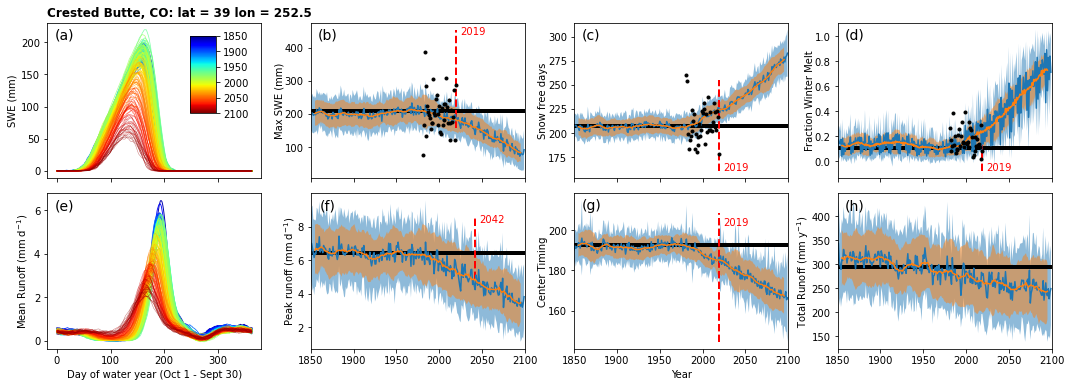

<Figure size 1296x432 with 0 Axes>

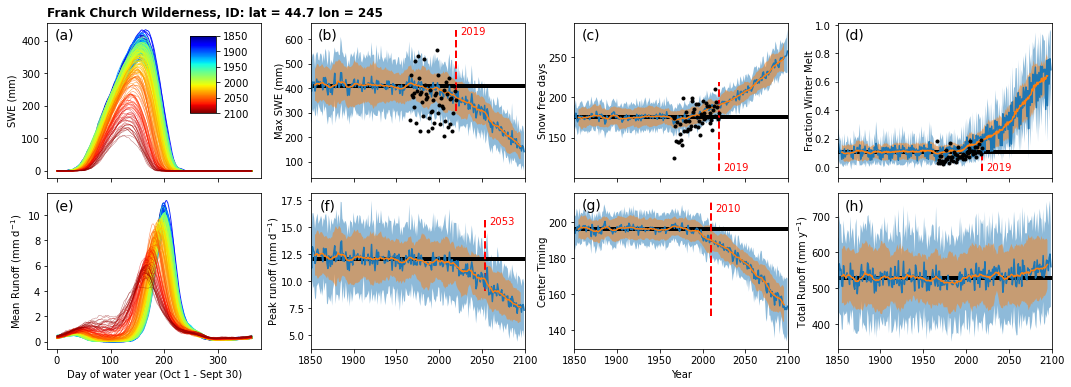

<Figure size 1296x432 with 0 Axes>

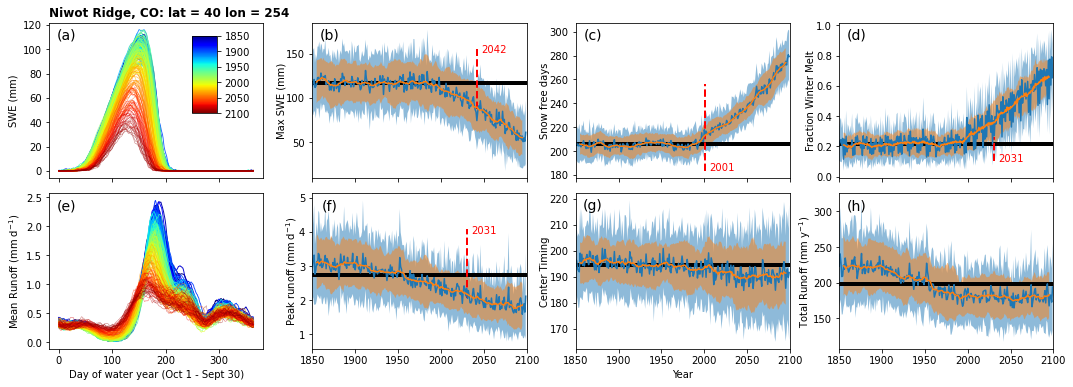

In [36]:
day_vars = ['H2OSNO','QRUNOFF']
in_vars = ['MaxSnow','SnowFree','f_WinMELT',
           'MaxQrun','CT','TotQrun']
#           'MaxQrun','MaxQrunDate','TotQrun']
sno_vars = ['Max SWE (mm)', 'Snow free days', 'Fraction Winter Melt',
            'Peak runoff (mm $\mathregular{d^{-1}}$)',
            'Center Timing',
#            'Day of peak runoff',
            'Total Runoff (mm $\mathregular{y^{-1}}$)']
sno_trend = ['neg','pos','pos',
             'neg','neg','neg']
ID = ['(b)','(c)','(d)','(f)','(g)','(h)']
fout = ['Fig1','FigS2','FigSx']

#select the site to plot here
for p in range(len(site)):
    print('-- '+site[p]+' --')
    plt.figure(figsize=[18,6])
    fig, axs = plt.subplots(2,4, sharex='col',
                            gridspec_kw={'wspace': 0.23, 'hspace': 0.1},
                            figsize=(18,6))


    nspan = 1
    nyear = int(len(year)/nspan)
    alpha = np.linspace(1.,0.5,nyear) 
    lw = np.linspace(1.,0.5,nyear) 

    i,j = 0,0
    ## Plot chagnes in the annual cycle
    for i in range(2):
        color = iter(cm.jet(np.linspace(0,1,nyear)))
        for yr in range(nyear-1):
            #print(year[(i*nspan)])
            firstDay = 365*yr*nspan
            lastDay = firstDay + 365
            #x = Y.time.isel(time=slice(firstDay,lastDay))
            y = Y.isel(time=slice(firstDay,lastDay), 
                       lat=p,lon=p)
            c = next(color)
            axs[i,j].plot(y[day_vars[i]],c=c,lw=lw[yr],alpha=alpha[yr]) 

        if i == 0: 
            axs[i,j].set_title(site[p]+': lat = '+str(plat[p])+' lon = '+str(plon[p]), 
                               loc='left', fontsize='large', fontweight='bold')
            axs[i,j].set_ylabel('SWE (mm)') 
            axs[i,j].annotate('(a)', xy=(0.08, 0.92), xycoords=axs[i,j].transAxes,
                        ha='center', va='center',fontsize=14) 

        else:
            axs[i,j].set_ylabel('Mean Runoff (mm $\mathregular{d^{-1}}$)') ;
            axs[i,j].set_xlabel('Day of water year (Oct 1 - Sept 30)') ;
            axs[i,j].annotate('(e)', xy=(0.08, 0.92), xycoords=axs[i,j].transAxes,
                        ha='center', va='center',fontsize=14) 

    ### Plot time series of annual metrics
    # move counter for panel
    i,j = 0,1
    for v in range(len(sno_vars)):
        # ens mean
        x = ds_ensMean.time
        y = ds_ensMean[in_vars[v]].sel(lat = plat[p], lon = plon[p], method='nearest')
        y2 = ds_ensStd[in_vars[v]].sel(lat = plat[p], lon = plon[p], method='nearest')

        axs[i,j].plot(x, y, '-')

        axs[i,j].fill_between(x, y - y2, y + y2, alpha=0.5)
        axs[i,j].set_ylabel(sno_vars[v],labelpad=0.) ;

        # rolling ensemble mean
        x = roll_ensMean.time
        y = roll_ensMean[in_vars[v]].sel(lat = plat[p], lon = plon[p], method='nearest')
        y2= roll_ensStd[in_vars[v]].sel(lat = plat[p], lon = plon[p], method='nearest')
        axs[i,j].plot(x, y)
        axs[i,j].set_xlim(1850,2100)
        axs[i,j].fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

        # baseline
        axs[i,j].hlines(dsBase[in_vars[v]].sel(
            lat = plat[p], lon = plon[p], method='nearest'), 
                        1850, 2100, colors='k',lw=4) ;
        # snowtel, obs S Rockies
        if p == 0:
            if i == 0:
                x = obsIN.time
                if j == 1:
                    y = obsIN.southRockies_maxSWE_subset.mean('soRockiesSNOTEL_subset')
                if j == 2:
                    y = obsIN.southRockies_snowFree_subset.mean('soRockiesSNOTEL_subset')
                if j == 3:
                    #y = obsIN.southRockies_fracMelt_30yrs.mean('soRockiesSNOTEL_30yrs')
                    y = obsIN.southRockies_fracMelt_subset.mean('soRockiesSNOTEL_subset')
                axs[i,j].plot(x, y, '.',color='k')
        # snowtel, obs, N Rockies
        if p == 1:
            if i == 0:
                x = obsIN.time
                if j == 1:
                    y = obsIN.northRockies_maxSWE_subset.mean('noRockiesSNOTEL_subset')
                if j == 2:
                    y = obsIN.northRockies_snowFree_subset.mean('noRockiesSNOTEL_subset') 
                if j == 3:
                    #y = obsIN.northRockies_fracMelt_30yrs.mean('noRockiesSNOTEL_30yrs')
                    y = obsIN.northRockies_fracMelt_subset.mean('noRockiesSNOTEL_subset')
                axs[i,j].plot(x, y, '.',color='k')

        # find last year when roll mean - 2 std < baseline
        if sno_trend[v] == 'pos':  # variables w/ positive trend:
            test = y - 2*y2
            test = test.where(test<dsBase[in_vars[v]].sel(
                lat = plat[p], lon = plon[p], method='nearest')).dropna('time')
        else:
            test = y + 2*y2
            test = test.where(test>dsBase[in_vars[v]].sel(
                lat = plat[p], lon = plon[p], method='nearest')).dropna('time')

        ToE = test.time.isel(time=-1)
        #draw ToE lines
        if ToE <2095:
            if sno_trend[v] == 'pos': 
                axs[i,j].vlines(ToE, test.min()*0.95,test.max()*1.25,colors='r',
                                lw=2,linestyles='dashed') ;
                axs[i,j].text(ToE+5, test.min()*0.95, 
                              np.int32(ToE.values),color='r')
            else: 
                axs[i,j].vlines(ToE, test.min()*0.75,test.max()*1.04,colors='r',
                                lw=2,linestyles='dashed') ;
                axs[i,j].text(ToE+5, test.max()*1.01, 
                              np.int32(ToE.values) ,color='r')
        #add panel label
        axs[i,j].annotate(ID[v], xy=(0.08, 0.92), xycoords=axs[i,j].transAxes,
                        ha='center', va='center',fontsize=14) 
        if v == 4:
            axs[i,j].set_xlabel('Year') ;

        # move counter for panel
        j = j+1
        if j == 4:
            i = i+1
            j = 1 ;


    # Fake a ScalarMappable so you can display a colormap
    nvalues=nyear
    cmap, norm = mcolors.from_levels_and_colors(range(1850,2101), 
                                                cm.jet(np.linspace(0,1,(nyear-1))))
    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    #Specifying figure coordinates works fine:
    fig_coord = [0.235,0.67,0.02,0.18]
    cbar_ax = fig.add_axes(fig_coord)

    # tick mark levels
    clevs = [1850,1900,1950,2000,2050,2100]

    fig.colorbar(sm,cax=cbar_ax,
                 orientation='vertical', 
                 ticks=clevs).ax.invert_yaxis() ;
    pathIN = '/glade/scratch/wwieder/VernalWindow/'
    fileOUT =  pathIN + fout[p]+'.pdf' 
    print(fileOUT)
    plt.savefig(fileOUT) ;
;

-------------------
# End of working code...

In [44]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python

Last updated: 2021-05-21

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.21.0

Git hash: 5fe5aa3c1e3d5fcc6190e7aa9830d7a091da527e

Git repo: https://github.com/wwieder/cesm-lens.git

Git branch: main

cartopy   : 0.18.0
xarray    : 0.17.0
scipy     : 1.6.0
cftime    : 1.4.1
dask      : 2021.2.0
numba     : 0.52.0
matplotlib: 3.3.4
pandas    : 1.2.3
numpy     : 1.20.1



In [45]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
